# Milestone Part 2 - Music Clustering Using Spotify API

Music is always evolving, and at the core of its evolution is the formation of new genres and the reimagination of existing genres. Genres are created and reformed due to the fluidity of their inherent characteristics. Qualities such as form, style, and subject matter are in flux and can overlap between genres and subgenres. The main motivation for this music genre classification project was to explore the differences between genres: how well-defined genre boundaries are according to the sonic characteristics of songs as well as whether an unsupervised learning model would generate classifications similar to an average music listener. It's theorized that the borders between genres are becoming blurred and that the broad classifications are similar. To test this theory, audio data for 3089 songs from 11 different genres is collected via the Spotipy API, further audio features are extracted via the Librosa library, K-Means and Agglomerative Clustering is performed with both PCA and t-SNE dimensionality reduction techniques, and clusters are compared using the Davies-Bouldin and Calinski-Harabasz scores. 

Spotipy, a Python library designed to integrate with the Spotify Web API, was used to extract audio information from playlists spanning across a number of genres including rock, metal, indie, EDM, hip hop, pop, rap, country, classical, Latin, and K-pop. We collected 6 playlists for each genre and used Spotipy to collect details and characteristics about each song including acousticness, danceability, energy, key, loudness, mode, speechiness, instrumentalness, liveness, valence, tempo, duration, and time signature. Mp3s from each song’s 30 second preview are also collected.

In [1]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials, SpotifyOAuth
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

#Set credentials
SPOTIPY_CLIENT_ID = '5df696031fe04b50b2bd7b434a7be855'
SPOTIPY_CLIENT_SECRET = '94c29af31f4a463bbf54d8bec5e17102'

spotify = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials(
                                                                                client_id = SPOTIPY_CLIENT_ID,
                                                                                client_secret = SPOTIPY_CLIENT_SECRET
                                                                                ))

In [2]:
def extract_from_playlists(playlist_list, genre):
    
     # Create empty dataframe
    features = ["track_name","track_uri","track_preview", "track_link","artist_name","artist_uri","album_name","album_image", "genre", "acousticness", "danceability","energy","key","loudness","mode", "speechiness","instrumentalness","liveness","valence","tempo", "duration_ms","time_signature"]
    
    #Pd dataframe to ultimately get
    genre_df = pd.DataFrame(columns=features)
    
    for playlist in playlist_list:
        
        #Get info for all tracks
        playlist_information = spotify.playlist_items(playlist)['items']
        # If you wanted to inspect one playlist, do the below:
        #spotify.playlist_items('37i9dQZF1DWXRqgorJj26U', limit=1, fields='items(track(uri, name, preview_url, external_urls(spotify), artists(name, uri), album(name, uri, images)))')        
        
        #Append info for all tracks to playlist
        for track in playlist_information:
            # Create empty dict
            playlist_features = {}
            # Get metadata
            #Track Information
            playlist_features["track_name"] = track["track"]["name"]
            playlist_features["track_uri"] = track["track"]["uri"]
            playlist_features["track_preview"] = track["track"]["preview_url"]
            playlist_features["track_link"] = track["track"]["external_urls"]["spotify"]
            #Artist Info
            playlist_features["artist_name"] = track["track"]["artists"][0]["name"]
            playlist_features["artist_uri"] = track["track"]["artists"][0]["uri"]
            #Album Info
            playlist_features["album_name"] = track["track"]["album"]["name"]
            playlist_features["album_uri"] = track["track"]["album"]["uri"]
            try:
                playlist_features["album_image"] = track["track"]["album"]["images"][1]["url"] #Some don't have images
            except:
                playlist_features["album_image"] = None
            #Add genre column
            playlist_features["genre"] = genre
            
            # Get audio features (should be in preview, but here's the spotipy way) 
            #("danceability","energy","key","loudness","mode", "speechiness","instrumentalness","liveness","valence","tempo", "duration_ms","time_signature")
            audio_features = spotify.audio_features(playlist_features["track_uri"])[0]
            
            for feature in features[9:]:
                try:
                    playlist_features[feature] = audio_features[feature]
                except:
                    playlist_features[feature] = None
                
            # Concat playlist_features into genre_df
            track_df = pd.DataFrame(playlist_features, index = [0])
            genre_df = pd.concat([genre_df, track_df], ignore_index = True)
    
    #Drop duplicates within genre... Overlap between genres is actually of interest, however
    genre_df.drop_duplicates(subset=['track_uri'], keep='last', inplace=True)
             
    return genre_df   

The public Spotify playlists that had audio data extracted from are shown below in the form of Spotify playlist IDs. To gain a more "professional" opinion of what songs belonged to which genre, most of the playlists were created by Spotify employees, although some are merely popular playlists to add more variety.

In [3]:
# Rock Classics, , 70s/80s/90s Rock Classics, 00s Rock Anthems, 10s Rock Anthmems, Rock This Presents... Best Rock Songs of 2020, Rock Party
rock_playlists = ['37i9dQZF1DWXRqgorJj26U', '6TCFeih29kBcaJIOtQRhpM', '37i9dQZF1DX3oM43CtKnRV', '37i9dQZF1DX99DRG9N39X3', '37i9dQZF1DX2UyG74cWOyT', '37i9dQZF1DX8FwnYE6PRvL'] 

# 80s Metal and Rock, 90s Metal Classics, 00s Metal Classics, 10s Metal Classics, 2020 Best Metal, Metal Workout Music
metal_playlists = ['5IpUo2kdDyRf64brc5i7Zg', '37i9dQZF1DX08jcQJXDnEQ', '37i9dQZF1DWXNFSTtym834', '37i9dQZF1DWUnhhRs5u3TO', '41mj3UeexIKCyNeMSlRoQM', '4WZS2CWrUd86DUDJnsdXEq']

# Best of 90s Indie/Alternative 90s, Indie Pop 2000s, Indie Pop 2010s, Best Indie Songs of 2020, Indie Chillout, Indie Vibes 2021
indie_playlists = ['7mSKLWxwFVXjzNzPpXMSSL', '37i9dQZF1DX9LbdoYID5v7','37i9dQZF1DXaLaoaQqrfyO', '37i9dQZF1DWWkGXMGv9j4M', '37i9dQZF1DX9B1hu73DioC', '20WquGIaof2g2KjBdve5RJ']

#2013-15 EDM Hits, Shuffle Syndrome(House), 2017-2018 EDM Hits, 'Electric Forest 2019', Best EDM Songs of 2020, Lost Lands 2019
EDM_playlists = ['3vdYDhTPS1399eLUzsrPJE','37i9dQZF1DWUq3wF0JVtEy','0PXy8VjpwVrNGv7IJ7omXG', '7glOXuVT007TTFrg2WQz2B', '37i9dQZF1DX1YoFrBCMpS8', '2goycBaUW1Pp8LSx3GRwCT']

#I love my 90s Hip Hop, 2000s hip hop, Hip Hop Hits of the 2010s, Beast Mode Hip Hop, Hip Hop Favorites, Hip Hop Controller
hiphop_playlists = ['37i9dQZF1DX186v583rmzp', '01pNIDYGqmeawppy32wr3D', '2ofwdpdDrR3pAdVp0kXa6j', '37i9dQZF1DX9oh43oAzkyx', '37i9dQZF1DX48TTZL62Yht', '37i9dQZF1DWT5MrZnPU1zD']

# 2000s Pop Party, 2010s Pop Playlist, Top 100 Pop Tracks, Pop Up, Pop Party, Pop Internacional
pop_playlists = ['5JdrbiLfh3yupiAByJwEWi', '50U0AhJcCUUNnk4Ott8RtB', '3ZgmfR6lsnCwdffZUan8EA', '37i9dQZF1DX6aTaZa0K6VA', '37i9dQZF1DWXti3N4Wp5xy', '37i9dQZF1DX1ngEVM0lKrb']

# Rap Oldies 80s/ 90s, Best Rap Songs of 2000s, Best of 2010s Rap, Rap Caviar, Turn up Party Rap 2021, Rap Hits 2015-2021
rap_playlists = ['6LCxF8bokUOGdRyM9G8g7I', '37i9dQZF1DX38t16fuNXJJ', '2z0FUpoDtfS5uIMXGT0iYN', '37i9dQZF1DX0XUsuxWHRQd', '5sl7pDQc5iLvTYsMpCGeuE', '72kAnCjd59qaVqiQTcDPwD']

#90s Country, 00s Country, 10s Country, Top Country Hits Today, Best Country 2020, Faster Horses 2021
country_playlists = ['3W8sIVX1FigsYLh4344d8R', '37i9dQZF1DXdxUH6sNtcDe', '4FPZhnxy0ooHoJvurFsCJl', '7d85RPHimZb0gR4PlY3IKq', '37i9dQZF1DWYvU2z6HruAo', '3sSwx6TMJ9OjEYPRnbgDYS'] 

#16th-17th Century, 18th Century VIllains, 19th-20th Century, Classical Essentials, Movie/ Orchestra Music, Classical Focus
classical_playlists = ['4KsjL3T9JqQxSMdRllftdC', '40wNQiST9qJiga8BHFKvwa', '34IzRrDlkAWYw9qd4sQstb', '37i9dQZF1DWWEJlAGA9gs0', '0ga9ko5UYM6I2G4tnLtCZH', '37i9dQZF1DXd5zUwdn6lPb']

#90s Latino, 00s Latino, 10s Latino, Latino Hits 2020/2021, Latin Hit Mix, Viva Latino
latin_playlists = ['37i9dQZF1DX4g1k3dwPPvk', '37i9dQZF1DWWfSNTZNgABD', '37i9dQZF1DWZQkHAMKYFuV', '7vI0tN3yUn07dkK9T6p2pg', '37i9dQZF1DXbLMw3ry7d7k', '37i9dQZF1DX10zKzsJ2jva']

#90s KPOP, 00s KPOP, all out 10s: KPOP, K-Pop Daebak, K-Club Party, K-Pop 2021 Hits kr
kpop_playlists = ['2Ktk2LlapzvJjFju1hpynQ', '2MmGjy62ky7f18Jbb0uCeS', '7CAl43cyaJEyqpJTOsXX7D', '37i9dQZF1DX9tPFwDMOaN1', '37i9dQZF1DX4RDXswvP6Mj', '3kwb1LyzCSsLLacppOJQc8']

In [4]:
#Extract audio data pertaining to rock songs
rock_df = extract_from_playlists(rock_playlists, 'Rock')
rock_df.sample(5)

acousticness                                        album_image  \
255       0.00305  https://i.scdn.co/image/ab67616d00001e0295d1d9...   
508       0.03370  https://i.scdn.co/image/ab67616d00001e02b07e5a...   
28        0.40800  https://i.scdn.co/image/ab67616d00001e022dac7a...   
438       0.00173  https://i.scdn.co/image/ab67616d00001e0282c0d7...   
440       0.02820  https://i.scdn.co/image/ab67616d00001e02d4d492...   

                   album_name                             album_uri  \
255            Bleed American  spotify:album:0UJhhj5bn5AGAjryFnhueP   
508               Mellow Gold  spotify:album:0iIGP4Sxw3KR4OCFv2yvz8   
28        Surrealistic Pillow  spotify:album:6lPb7Eoon6QPbscWbMsk6a   
438  DOA [Feat. Joyner Lucas]  spotify:album:4mcoqib00QAFwabXPGH9kY   
440    Tickets To My Downfall  spotify:album:57lgFncHBYu5E3igZnuCJK   

            artist_name                             artist_uri  danceability  \
255     Jimmy Eat World  spotify:artist:3Ayl7mCk0nScecqOzvNp6s         0.487   
508                Beck  spotify:artist:3vbKDsSS70ZX9D2OcvbZmS         0.654   
28   Jefferson Airplane  spotify:artist:2qFr8w5sWUITRlzZ9kZotF         0.504   
438           I Prevail  spotify:artist:3Uobr6LgQpBbk6k4QGAb3V         0.372   
440   Machine Gun Kelly  spotify:artist:6TIYQ3jFPwQSRmorSezPxX         0.691   

    duration_ms  energy genre  ...  loudness mode  speechiness    tempo  \
255      220027   0.898  Rock  ...    -4.436    1       0.0380  135.331   
508      235000   0.611  Rock  ...   -10.450    1       0.1190   85.387   
28       174840   0.578  Rock  ...    -9.302    1       0.0310  132.411   
438      218571   0.479  Rock  ...    -8.218    1       0.0411  175.134   
440      143901   0.770  Rock  ...    -4.578    0       0.0367   90.024   

    time_signature                                         track_link  \
255              4  https://open.spotify.com/track/429IbFR4yp2J81C...   
508              4  https://open.spotify.com/track/5PntSbMHC1ud6Vv...   
28               4  https://open.spotify.com/track/4uGIJG1jYFonGc4...   
438              4  https://open.spotify.com/track/78fUyqhfdpL5aaD...   
440              4  https://open.spotify.com/track/3k0YJnqMKRZb8sw...   

                   track_name  \
255                 Sweetness   
508                     Loser   
28           Somebody to Love   
438  DOA [Feat. Joyner Lucas]   
440                drunk face   

                                         track_preview  \
255                                               None   
508                                               None   
28   https://p.scdn.co/mp3-preview/2bbbf1d141efc87d...   
438                                               None   
440                                               None   

                                track_uri valence  
255  spotify:track:429IbFR4yp2J81CeTwF5iY   0.597  
508  spotify:track:5PntSbMHC1ud6Vvl8x56qd   0.786  
28   spotify:track:4uGIJG1jYFonGc4LGp5uQL   0.654  
438  spotify:track:78fUyqhfdpL5aaD12QSGCi   0.080  
440  spotify:track:3k0YJnqMKRZb8swo86vCkq   0.344  

[5 rows x 23 columns]

In [5]:
#Extract audio data pertaining to metal songs
metal_df = extract_from_playlists(metal_playlists, 'Metal')
metal_df.sample(5)

acousticness                                        album_image  \
395      0.000193  https://i.scdn.co/image/ab67616d00001e02a7e7bf...   
71       0.021400  https://i.scdn.co/image/ab67616d00001e02c8e539...   
162      0.002150  https://i.scdn.co/image/ab67616d00001e025f4ac3...   
506      0.000072  https://i.scdn.co/image/ab67616d00001e021fc03a...   
397      0.000395  https://i.scdn.co/image/ab67616d00001e02c6ea6f...   

                   album_name                             album_uri  \
395                        13  spotify:album:5WXL9YjbNd4GIqWc9mZOOq   
71   Appetite For Destruction  spotify:album:5JKFiC2WVi9HtvJEm8CUB8   
162             Rust In Peace  spotify:album:4e6ML9RBhDyyKTaTwbiRZv   
506              Perseverance  spotify:album:2UPZ06izR1OtTX80U30AfG   
397                  Holy War  spotify:album:6RVxuiGDPJ6DMHQNyTFGv9   

           artist_name                             artist_uri  danceability  \
395      Black Sabbath  spotify:artist:5M52tdBnJaKSvOpJGz8mfZ         0.379   
71       Guns N' Roses  spotify:artist:3qm84nBOXUEQ2vnTfUTTFC         0.274   
162           Megadeth  spotify:artist:1Yox196W7bzVNZI7RBaPnf         0.405   
506          Hatebreed  spotify:artist:17Mb968quDHpjCkIyq30QV         0.585   
397  Thy Art Is Murder  spotify:artist:3et9upNERQI5IYt5jEDTxM         0.195   

    duration_ms  energy  genre  ...  loudness mode  speechiness    tempo  \
395      532267   0.726  Metal  ...    -4.935    0       0.0332  120.012   
71       406307   0.949  Metal  ...    -8.642    1       0.0896  100.346   
162      322933   0.932  Metal  ...   -11.151    1       0.0929  194.639   
506      178667   0.907  Metal  ...    -4.787    1       0.1020   92.634   
397      240240   0.995  Metal  ...    -3.780    1       0.2600   90.753   

    time_signature                                         track_link  \
395              4  https://open.spotify.com/track/3IKJNHnVZ2bXGjA...   
71               4  https://open.spotify.com/track/5Q41NLTmGbVPozw...   
162              4  https://open.spotify.com/track/4GMQOjbWshf4Mzp...   
506              4  https://open.spotify.com/track/4Lxn1JlGJwmmXpO...   
397              3  https://open.spotify.com/track/6lW9QropoC5S6Rf...   

           track_name track_preview                             track_uri  \
395      God Is Dead?          None  spotify:track:3IKJNHnVZ2bXGjAFBJiUYo   
71      Paradise City          None  spotify:track:5Q41NLTmGbVPozwHKK7bk2   
162  Tornado Of Souls          None  spotify:track:4GMQOjbWshf4Mzphkjg0DJ   
506   I Will Be Heard          None  spotify:track:4Lxn1JlGJwmmXpODrNvPA6   
397          Holy War          None  spotify:track:6lW9QropoC5S6Rf5ttvP49   

    valence  
395   0.178  
71    0.497  
162   0.408  
506   0.573  
397   0.147  

[5 rows x 23 columns]

In [6]:
#Extract audio data pertaining to indie songs
indie_df = extract_from_playlists(indie_playlists, 'Indie')
indie_df.sample(5)

acousticness                                        album_image  \
383        0.1050  https://i.scdn.co/image/ab67616d00001e0217b9a1...   
177        0.1250  https://i.scdn.co/image/ab67616d00001e023d4b71...   
139        0.0416  https://i.scdn.co/image/ab67616d00001e020672b0...   
527        0.1640  https://i.scdn.co/image/ab67616d00001e02ac9c22...   
323        0.6460  https://i.scdn.co/image/ab67616d00001e02f3df35...   

                   album_name                             album_uri  \
383                 Sometimes  spotify:album:7LPsBxxixuOPJl7grf3PX3   
177  Somebody Else (Alt Edit)  spotify:album:3gInuvCjtLEy3LCWxZ4ZYF   
139    Lungs (Deluxe Edition)  spotify:album:2FgknX5e7fJlriQtxvpLhZ   
527               Cruel World  spotify:album:2ewne648qmoxjdcSUTIMQK   
323                Paper Thin  spotify:album:33fybrWr3dFLVT8ZViCSc7   

                artist_name                             artist_uri  \
383               Goth Babe  spotify:artist:7o96HO2zrujyATtVsqGhh3   
177                The 1975  spotify:artist:3mIj9lX2MWuHmhNCA7LSCW   
139  Florence + The Machine  spotify:artist:1moxjboGR7GNWYIMWsRjgG   
527            Active Child  spotify:artist:54KTsBl98buzGkELjGlnuU   
323         Lianne La Havas  spotify:artist:2RP4pPHTXlQpDnO9LvR7Yt   

     danceability duration_ms  energy  genre  ...  loudness mode  speechiness  \
383         0.445      262737   0.563  Indie  ...    -8.904    1       0.0315   
177         0.658      241973   0.834  Indie  ...    -5.240    1       0.0631   
139         0.492      251840   0.810  Indie  ...    -5.315    1       0.0847   
527         0.480      306773   0.520  Indie  ...    -9.529    1       0.0419   
323         0.714      298720   0.243  Indie  ...   -13.513    1       0.0479   

       tempo time_signature  \
383   94.978              4   
177  101.023              4   
139  149.954              4   
527   75.493              4   
323  125.832              4   

                                            track_link  \
383  https://open.spotify.com/track/7oJmIBxEAYjfkS7...   
177  https://open.spotify.com/track/4fnctse2eIRf7dv...   
139  https://open.spotify.com/track/1YLJVmuzeM2YSUk...   
527  https://open.spotify.com/track/0iByHgOtRyd96SF...   
323  https://open.spotify.com/track/1rV59uezLaLErSy...   

                   track_name  \
383                 Sometimes   
177  Somebody Else - Alt Edit   
139         Dog Days Are Over   
527               Cruel World   
323                Paper Thin   

                                         track_preview  \
383  https://p.scdn.co/mp3-preview/c813b527f7c65ba5...   
177                                               None   
139                                               None   
527                                               None   
323                                               None   

                                track_uri valence  
383  spotify:track:7oJmIBxEAYjfkS7lhZ7M1S   0.204  
177  spotify:track:4fnctse2eIRf7dvOhIGO4P   0.605  
139  spotify:track:1YLJVmuzeM2YSUkCCaTNUB   0.245  
527  spotify:track:0iByHgOtRyd96SFdlXP2Xc   0.114  
323  spotify:track:1rV59uezLaLErSyjNHPhTJ   0.504  

[5 rows x 23 columns]

In [7]:
#Extract audio data pertaining to EDM songs
EDM_df = extract_from_playlists(EDM_playlists, 'EDM')
EDM_df.sample(5)

acousticness                                        album_image  \
41        0.05850  https://i.scdn.co/image/ab67616d00001e02aed595...   
161       0.09300  https://i.scdn.co/image/ab67616d00001e028d12bc...   
146       0.00501  https://i.scdn.co/image/ab67616d00001e02029f67...   
237       0.20200  https://i.scdn.co/image/ab67616d00001e023bbca5...   
470       0.00338  https://i.scdn.co/image/ab67616d00001e025b62a8...   

             album_name                             album_uri    artist_name  \
41               Levels  spotify:album:4mkvtXQd6rD7zuAHhexEvb         Avicii   
161              My Way  spotify:album:0dzeoQhVNzKkwM5ieOJC54  Calvin Harris   
146               Thief  spotify:album:7dms5U2FoSQN4Gg3Odga5G          Ookay   
237          Still Here  spotify:album:2MrG5RkVpWPxTlXt0yfGXO      iann dior   
470  RENEGADES OF LIGHT  spotify:album:4KVo7hcHmc7x12sszqdLAN        LSDREAM   

                                artist_uri  danceability duration_ms  energy  \
41   spotify:artist:1vCWHaC5f2uS3yhpwWbIA6         0.620      199904   0.881   
161  spotify:artist:7CajNmpbOovFoOoasH2HaY         0.818      219160   0.913   
146  spotify:artist:1HQGhla3VNj1dBmKTtVT2t         0.555      239711   0.807   
237  spotify:artist:6ASri4ePR7RlsvIQgWPJpS         0.677      112000   0.552   
470  spotify:artist:3Hrqjumb6WHg2aAUHJHLND         0.600      226707   0.901   

    genre  ...  loudness mode  speechiness    tempo time_signature  \
41    EDM  ...    -5.851    0       0.0372  126.035              4   
161   EDM  ...    -3.060    0       0.0426  119.986              4   
146   EDM  ...    -2.997    1       0.0543  149.894              4   
237   EDM  ...    -6.880    0       0.0482   90.008              4   
470   EDM  ...    -3.754    1       0.1010   95.014              4   

                                            track_link           track_name  \
41   https://open.spotify.com/track/0JhKJg5ejeQ8jq8...  Levels - Radio Edit   
161  https://open.spotify.com/track/1vvNmPOiUuyCbgW...               My Way   
146  https://open.spotify.com/track/1FJdcvpJVfrGSIl...                Thief   
237  https://open.spotify.com/track/6UoRwDlcwTzajgP...  don't wanna believe   
470  https://open.spotify.com/track/0Jh5xZwo7IeUQkf...  EXPAND THE UNIVERSE   

                                         track_preview  \
41                                                None   
161  https://p.scdn.co/mp3-preview/574c5ea96188f94f...   
146                                               None   
237                                               None   
470  https://p.scdn.co/mp3-preview/2b8d6d2a49d4d094...   

                                track_uri valence  
41   spotify:track:0JhKJg5ejeQ8jq89UQtnw8   0.415  
161  spotify:track:1vvNmPOiUuyCbgWmtc6yfm   0.536  
146  spotify:track:1FJdcvpJVfrGSIltpgltDd   0.199  
237  spotify:track:6UoRwDlcwTzajgPvAxuyT4   0.363  
470  spotify:track:0Jh5xZwo7IeUQkf4Vbzxvq   0.218  

[5 rows x 23 columns]

In [8]:
#Extract audio data pertaining to hip hop songs
hiphop_df = extract_from_playlists(hiphop_playlists, 'Hip Hop')
hiphop_df.sample(5)

acousticness                                        album_image  \
51         0.0965  https://i.scdn.co/image/ab67616d00001e022f5854...   
43         0.0346  https://i.scdn.co/image/ab67616d00001e02a786ad...   
528        0.0274  https://i.scdn.co/image/ab67616d00001e02a163e9...   
364        0.0111  https://i.scdn.co/image/ab67616d00001e028e58e8...   
440        0.0808  https://i.scdn.co/image/ab67616d00001e0236f15d...   

                         album_name                             album_uri  \
51                        Soul Food  spotify:album:3FmGFdxsTsirg84H5ebR8x   
43                   All Eyez On Me  spotify:album:4CzT5ueFBRpbILw34HQYxi   
528                     Money On Me  spotify:album:6stWrZRWkovGgmiXkWtJlk   
364  Stuntin' On You (feat. DaBaby)  spotify:album:0ntJqUFZt7XQmRycj6typz   
440                 Good Intentions  spotify:album:0jk3nAmtiIfwLU4CvDDMaS   

    artist_name                             artist_uri  danceability  \
51   Goodie Mob  spotify:artist:3F2Y683ovlWT53WKCeq0oj         0.849   
43         2Pac  spotify:artist:1ZwdS5xdxEREPySFridCfh         0.763   
528        Russ  spotify:artist:1z7b1Pr1rSlvWRzsW3HOrS         0.929   
364  Tyla Yaweh  spotify:artist:1MXZ0hsGic96dWRDKwAwdr         0.796   
440         NAV  spotify:artist:7rkW85dBwwrJtlHRDkJDAC         0.894   

    duration_ms  energy    genre  ... loudness mode  speechiness    tempo  \
51       277133   0.476  Hip Hop  ...  -10.479    1       0.4450   83.210   
43       287547   0.840  Hip Hop  ...   -3.704    1       0.0929   92.477   
528      142520   0.450  Hip Hop  ...   -7.520    0       0.0840  124.996   
364      141123   0.683  Hip Hop  ...   -5.165    0       0.2770  173.852   
440      161320   0.618  Hip Hop  ...   -4.356    0       0.1290  119.100   

    time_signature                                         track_link  \
51               4  https://open.spotify.com/track/3MX96tMiJxVu7lQ...   
43               4  https://open.spotify.com/track/1eduDdsjMO7Or4E...   
528              4  https://open.spotify.com/track/2OAZWC4eQR6b1DW...   
364              3  https://open.spotify.com/track/341lTIxmhybbQsg...   
440              4  https://open.spotify.com/track/7IMwEtpAiJanqF6...   

                                track_name  \
51                            Cell Therapy   
43                      How Do You Want It   
528                            Money On Me   
364         Stuntin' On You (feat. DaBaby)   
440  Turks (with Gunna & ft. Travis Scott)   

                                         track_preview  \
51                                                None   
43                                                None   
528  https://p.scdn.co/mp3-preview/ca4b846b1354c816...   
364  https://p.scdn.co/mp3-preview/c38f43f36b3e8840...   
440                                               None   

                                track_uri valence  
51   spotify:track:3MX96tMiJxVu7lQWKbgo2c   0.480  
43   spotify:track:1eduDdsjMO7Or4EXnMf2iS   0.748  
528  spotify:track:2OAZWC4eQR6b1DWrjmZldh   0.387  
364  spotify:track:341lTIxmhybbQsgydwJiFx   0.737  
440  spotify:track:7IMwEtpAiJanqF6vQteZN2   0.379  

[5 rows x 23 columns]

In [9]:
#Extract audio data pertaining to pop songs
pop_df = extract_from_playlists(pop_playlists, 'Pop')
pop_df.sample(5)

acousticness                                        album_image  \
299        0.1810  https://i.scdn.co/image/ab67616d00001e024b02db...   
33         0.1210  https://i.scdn.co/image/ab67616d00001e02863098...   
176        0.5580  https://i.scdn.co/image/ab67616d00001e024b1899...   
486        0.0151  https://i.scdn.co/image/ab67616d00001e02caaa45...   
24         0.0460  https://i.scdn.co/image/ab67616d00001e0295c8b0...   

                                            album_name  \
299                                             Anyone   
33          The Boombastic Collection - Best of Shaggy   
176  Frozen (Original Motion Picture Soundtrack / D...   
486                               Doo-Wops & Hooligans   
24                                               Loose   

                                album_uri    artist_name  \
299  spotify:album:51kijm0sjZz0yOa3kVBPUU  Justin Bieber   
33   spotify:album:04bMI1jl7CB82LkdeHXyEo         Shaggy   
176  spotify:album:7lZs5r4oQV2nutddffLrg0   Idina Menzel   
486  spotify:album:6J84szYCnMfzEcvIcfWMFL     Bruno Mars   
24   spotify:album:1E7rOrC4uJb0YHyGJ6YOlC  Nelly Furtado   

                                artist_uri  danceability duration_ms  energy  \
299  spotify:artist:1uNFoZAHBGtllmzznpCI3s         0.686      190779   0.538   
33   spotify:artist:5EvFsr3kj42KNv97ZEnqij         0.805      235147   0.763   
176  spotify:artist:73Np75Wv2tju61Eo9Zw4IR         0.543      223840   0.485   
486  spotify:artist:0du5cEVh5yTK9QJze8zA0C         0.637      220733   0.843   
24   spotify:artist:2jw70GZXlAI8QzWeY2bgRc         0.795      242200   0.978   

    genre  ...  loudness mode  speechiness    tempo time_signature  \
299   Pop  ...    -8.026    1       0.0345  115.884              4   
33    Pop  ...    -2.955    1       0.0942   85.289              4   
176   Pop  ...    -6.850    1       0.0305  136.961              4   
486   Pop  ...    -5.413    1       0.0432  109.012              4   
24    Pop  ...    -6.097    0       0.0459  114.321              4   

                                            track_link  \
299  https://open.spotify.com/track/31qCy5ZaophVA81...   
33   https://open.spotify.com/track/2W31oMmNa2wHNya...   
176  https://open.spotify.com/track/0qcr5FMsEO85NAQ...   
486  https://open.spotify.com/track/47Slg6LuqLaX0Vo...   
24   https://open.spotify.com/track/47aQT2aV12Tyila...   

                                       track_name  \
299                                        Anyone   
33                                          Angel   
176  Let It Go - From "Frozen"/Soundtrack Version   
486                          Just the Way You Are   
24                                    Promiscuous   

                                         track_preview  \
299                                               None   
33                                                None   
176                                               None   
486  https://p.scdn.co/mp3-preview/07c6c33d6426d61f...   
24                                                None   

                                track_uri valence  
299  spotify:track:31qCy5ZaophVA81wtlwLc4   0.584  
33   spotify:track:2W31oMmNa2wHNyavreExkH   0.820  
176  spotify:track:0qcr5FMsEO85NAQjrlDRKo   0.371  
486  spotify:track:47Slg6LuqLaX0VodpSCvPt   0.434  
24   spotify:track:47aQT2aV12TyilaoYi1NiD   0.843  

[5 rows x 23 columns]

In [10]:
#Extract audio data pertaining to pop songs
rap_df = extract_from_playlists(rap_playlists, 'Rap')
rap_df.sample(5)

acousticness                                        album_image  \
484        0.3500  https://i.scdn.co/image/ab67616d00001e020671c1...   
429        0.1850  https://i.scdn.co/image/ab67616d00001e022c0a8b...   
409        0.2490  https://i.scdn.co/image/ab67616d00001e02a276d6...   
100        0.1510  https://i.scdn.co/image/ab67616d00001e02a53e29...   
407        0.0114  https://i.scdn.co/image/ab67616d00001e0215956f...   

                                 album_name  \
484                            Captain Hook   
429  ABC (feat. DJ Chose & LightSkinKeisha)   
409                             Participate   
100                           Tha Last Meal   
407                                    Luna   

                                album_uri         artist_name  \
484  spotify:album:1ScpeEwDjOM56tOz09z0Yg     Shordie Shordie   
429  spotify:album:7v0AiMm0AaYL27TLvifn41              thmpsn   
409  spotify:album:596kpAQHfEKS4l2IU3jqKs  Coupe D'Ville Slim   
100  spotify:album:71VPCdeQQs1dmyVbflhPjX          Snoop Dogg   
407  spotify:album:35GqAYLpVQDJpLEQ2TKb0n  Coupe D'Ville Slim   

                                artist_uri  danceability duration_ms  energy  \
484  spotify:artist:5fyvTyetDr7gvLafBsEEhU         0.762      134213   0.383   
429  spotify:artist:4RguKaIgVQ9Iep7mYAJ6J4         0.823      184136   0.808   
409  spotify:artist:0ve0hdg1TexbsoBGNX1BcS         0.796      143334   0.780   
100  spotify:artist:7hJcb9fa4alzcOq3EaNPoG         0.870      223000   0.653   
407  spotify:artist:0ve0hdg1TexbsoBGNX1BcS         0.812      151275   0.819   

    genre  ... loudness mode  speechiness    tempo time_signature  \
484   Rap  ...  -10.098    0        0.202   92.947              4   
429   Rap  ...   -4.906    1        0.183  153.982              4   
409   Rap  ...   -6.205    0        0.272   87.028              4   
100   Rap  ...   -4.353    1        0.326   94.840              4   
407   Rap  ...   -5.683    0        0.293   84.986              4   

                                            track_link  \
484  https://open.spotify.com/track/4dV3okcjbQwTcg4...   
429  https://open.spotify.com/track/2kH2FSUXyRRSBZb...   
409  https://open.spotify.com/track/4alyFWLEtxCYf1T...   
100  https://open.spotify.com/track/0YHI5hydPPth6J5...   
407  https://open.spotify.com/track/7ErkHMAKV5HO9VS...   

                                 track_name  \
484                               Bitchuary   
429  ABC (feat. DJ Chose & LightSkinKeisha)   
409                             Participate   
100                                 Lay Low   
407                                    Luna   

                                         track_preview  \
484  https://p.scdn.co/mp3-preview/ffab937d3825ce40...   
429  https://p.scdn.co/mp3-preview/e5eec46e29a50d55...   
409  https://p.scdn.co/mp3-preview/4a02e8971f020347...   
100                                               None   
407  https://p.scdn.co/mp3-preview/8e7012a421a40d53...   

                                track_uri valence  
484  spotify:track:4dV3okcjbQwTcg4ObIGr4N   0.441  
429  spotify:track:2kH2FSUXyRRSBZbz163WFM   0.648  
409  spotify:track:4alyFWLEtxCYf1TmVs4IH7   0.618  
100  spotify:track:0YHI5hydPPth6J5UOzdLDX   0.755  
407  spotify:track:7ErkHMAKV5HO9VS5I6ugdb   0.556  

[5 rows x 23 columns]

In [11]:
#Extract audio data pertaining to country songs
country_df = extract_from_playlists(country_playlists, 'Country')
country_df.sample(5)

acousticness                                        album_image  \
193        0.2740  https://i.scdn.co/image/ab67616d00001e0237490f...   
170        0.0664  https://i.scdn.co/image/ab67616d00001e02a7e1e1...   
364        0.3690  https://i.scdn.co/image/ab67616d00001e02f9f2dd...   
342        0.0386  https://i.scdn.co/image/ab67616d00001e02a80b3a...   
315        0.2310  https://i.scdn.co/image/ab67616d00001e02b55293...   

           album_name                             album_uri  \
193            Shiver  spotify:album:3Uzu7TMSJiHQNqkIEYFMjb   
170  Everywhere We Go  spotify:album:67qNNUSHekqSliS7Q1XZj6   
364      If I Know Me  spotify:album:1IR2nlwX6YVTXXeu2qzoWO   
342        Home Sweet  spotify:album:5O5Y7X9y24GiOijvy19ef8   
315         SOUTHSIDE  spotify:album:1xRcR4iSouBrfVhuqFkPAJ   

           artist_name                             artist_uri  danceability  \
193       Jamie O'Neal  spotify:artist:6sQVeggRv1AhrMzuCjhCZe         0.507   
170      Kenny Chesney  spotify:artist:3grHWM9bx2E9vwJCdlRv9O         0.689   
364      Morgan Wallen  spotify:artist:4oUHIQIBe0LHzYfvXNW4QM         0.614   
342  Russell Dickerson  spotify:artist:1E2AEtxaFaJtH0lO7kgNKw         0.580   
315           Sam Hunt  spotify:artist:2kucQ9jQwuD8jWdtR9Ef38         0.562   

    duration_ms  energy    genre  ... loudness mode  speechiness    tempo  \
193      182613   0.843  Country  ...   -3.421    1       0.1080  193.708   
170      248067   0.886  Country  ...   -7.066    0       0.0382  122.070   
364      234347   0.680  Country  ...   -4.580    1       0.0289  149.959   
342      205947   0.813  Country  ...   -5.621    1       0.0414  120.973   
315      215933   0.649  Country  ...   -5.400    1       0.0494  145.913   

    time_signature                                         track_link  \
193              4  https://open.spotify.com/track/6X1MOfJSjBT54Vc...   
170              4  https://open.spotify.com/track/3QV7NYkrmV0Q0IH...   
364              4  https://open.spotify.com/track/6foY66mWZN0pSRj...   
342              4  https://open.spotify.com/track/7xMFk2Vj2hALyMd...   
315              4  https://open.spotify.com/track/4sf2L157iEgAR7y...   

                           track_name  \
193         When I Think About Angels   
170      She Thinks My Tractor's Sexy   
364                   Whiskey Glasses   
342                        Home Sweet   
315  Breaking Up Was Easy In The 90's   

                                         track_preview  \
193                                               None   
170  https://p.scdn.co/mp3-preview/7c2575ea27b87e71...   
364  https://p.scdn.co/mp3-preview/95ac7dba403384cd...   
342  https://p.scdn.co/mp3-preview/dbdf767f5c0c89c2...   
315                                               None   

                                track_uri valence  
193  spotify:track:6X1MOfJSjBT54VcbD1o7vR   0.504  
170  spotify:track:3QV7NYkrmV0Q0IHdFJw9hO   0.906  
364  spotify:track:6foY66mWZN0pSRjZ408c00   0.707  
342  spotify:track:7xMFk2Vj2hALyMdzHFopJl   0.473  
315  spotify:track:4sf2L157iEgAR7yrCNLgSq   0.376  

[5 rows x 23 columns]

In [12]:
#Extract audio data pertaining to classical songs
classical_df = extract_from_playlists(classical_playlists, 'Classical')
classical_df.sample(5)

acousticness                                        album_image  \
132         0.986  https://i.scdn.co/image/ab67616d00001e02717e9f...   
289         0.757  https://i.scdn.co/image/ab67616d00001e027e82e2...   
229         0.955  https://i.scdn.co/image/ab67616d00001e02c77f2e...   
234         0.959  https://i.scdn.co/image/ab67616d00001e02c56724...   
193         0.983  https://i.scdn.co/image/ab67616d00001e028e6adf...   

                                            album_name  \
132               Ravel: Complete Works for Solo Piano   
289                             2001 - A Space Odyssey   
229  Grieg: Peer Gynt, Op. 23 (Excerpts) - Sony Cla...   
234  Butterworth: The Banks of Green Willow; A Shro...   
193                   Rachmaninov: Piano Concerto No.2   

                                album_uri              artist_name  \
132  spotify:album:5Ui8Uj9oHn2yT7Duo0welM            Maurice Ravel   
289  spotify:album:3AzJfHje1Uym5QC5vt7WKK          Richard Strauss   
229  spotify:album:2Rt1JJA8IvT38kzCyZksSP             Edvard Grieg   
234  spotify:album:1Szzhi5CI8U94YoUu8Zo2a  Samuel Coleridge-Taylor   
193  spotify:album:5lVqgXqdoIH3W1wUM2hzPx      Sergei Rachmaninoff   

                                artist_uri  danceability duration_ms  energy  \
132  spotify:artist:17hR0sYHpx7VYTMRfFUOmY         0.202      420187  0.1190   
289  spotify:artist:6pAwHPeExeUbMd5w7Iny6D         0.203      102533  0.2570   
229  spotify:artist:5ihY290YPGc3aY2xTyx7Gy         0.436      153267  0.1510   
234  spotify:artist:0fhN6BHa9pN66ZnsrI5NUR         0.224     1215573  0.0291   
193  spotify:artist:0Kekt6CKSo0m5mivKcoH51         0.194      644273  0.0545   

         genre  ...  loudness mode  speechiness    tempo time_signature  \
132  Classical  ...   -23.191    1       0.0383   66.477              4   
289  Classical  ...   -13.539    1       0.0333   84.006              4   
229  Classical  ...   -20.745    0       0.0603  103.777              4   
234  Classical  ...   -26.167    1       0.0455  121.131              4   
193  Classical  ...   -24.877    1       0.0366  140.966              4   

                                            track_link  \
132  https://open.spotify.com/track/0eoHzI456z8FK5o...   
289  https://open.spotify.com/track/4NxSCnqHDKgtUIR...   
229  https://open.spotify.com/track/3VQ7hwiEfaHDl3A...   
234  https://open.spotify.com/track/2ceu417OdiSxzR3...   
193  https://open.spotify.com/track/4rrrn8OLrttq7r9...   

                                            track_name  \
132  Ravel: Miroirs, M. 43: III. Une barque sur l'o...   
289                            Prelude (Sonnenaufgang)   
229  Peer Gynt, Op. 23: Act II, 7, In the Hall of t...   
234      Symphonic Variations on an African Air, Op.63   
193  Piano Concerto No. 2 in C Minor, Op. 18: 2. Ad...   

                                         track_preview  \
132  https://p.scdn.co/mp3-preview/17de283a6c9535d6...   
289                                               None   
229  https://p.scdn.co/mp3-preview/b48c93b823c027ee...   
234                                               None   
193                                               None   

                                track_uri valence  
132  spotify:track:0eoHzI456z8FK5o0g7pdGn  0.0289  
289  spotify:track:4NxSCnqHDKgtUIR3gxhuaF  0.0346  
229  spotify:track:3VQ7hwiEfaHDl3AySgyaiR  0.3590  
234  spotify:track:2ceu417OdiSxzR3K7B1n2M  0.0538  
193  spotify:track:4rrrn8OLrttq7r9RgNXalU  0.0385  

[5 rows x 23 columns]

In [13]:
#Extract audio data pertaining to latin songs
latin_df = extract_from_playlists(latin_playlists, 'Latin')
latin_df.sample(5)

acousticness                                        album_image  \
234       0.03640  https://i.scdn.co/image/ab67616d00001e0226ddcc...   
49        0.03070  https://i.scdn.co/image/ab67616d00001e02021b97...   
161       0.02580  https://i.scdn.co/image/ab67616d00001e027d4659...   
26        0.00488  https://i.scdn.co/image/ab67616d00001e025ddba0...   
386       0.08460  https://i.scdn.co/image/ab67616d00001e025fa6dc...   

           album_name                             album_uri       artist_name  \
234                 X  spotify:album:74D2cU8F6KbBqva3mnzrqI         Nicky Jam   
49     Pies Descalzos  spotify:album:3HLngzP9wVd8p3SMDQgyd9           Shakira   
161         Me Rehúso  spotify:album:6qIOlt2SVkfs9NynvpaQ1j       Danny Ocean   
26   16 Éxitos De Oro  spotify:album:6ugipz6Zx3IWPW4hGPP9Fk  Alejandra Guzman   
386             China  spotify:album:1PTTAq0OxggVgqP5WTYWDh          Anuel AA   

                                artist_uri  danceability duration_ms  energy  \
234  spotify:artist:1SupJlEpv7RS2tPNRaHViT         0.595      173628   0.773   
49   spotify:artist:0EmeFodog0BfCgMzAIvKQp         0.732      232467   0.814   
161  spotify:artist:5H1nN1SzW0qNeUEZvuXjAj         0.746      205741   0.794   
26   spotify:artist:7Hf9AwMO37bSdxHb0FBGmO         0.665      244293   0.936   
386  spotify:artist:2R21vXR83lH98kGeO99Y66         0.786      301714   0.808   

     genre  ... loudness mode  speechiness    tempo time_signature  \
234  Latin  ...   -4.736    0       0.0549  180.073              4   
49   Latin  ...   -7.716    1       0.0402  116.973              4   
161  Latin  ...   -6.331    1       0.0698  104.827              4   
26   Latin  ...   -3.463    1       0.0320  122.100              4   
386  Latin  ...   -3.702    1       0.0882  105.027              4   

                                            track_link     track_name  \
234  https://open.spotify.com/track/39N9RPD9MRb5Wmo...              X   
49   https://open.spotify.com/track/4M1lEbqPzlEw1JY...     Estoy Aquí   
161  https://open.spotify.com/track/6Zosz8w6CmdGMZM...      Me Rehúso   
26   https://open.spotify.com/track/7xSvBMiquYNDfg1...  Mirala Miralo   
386  https://open.spotify.com/track/2ksOAxtIxY8yElE...          China   

                                         track_preview  \
234                                               None   
49   https://p.scdn.co/mp3-preview/9487455c1952feb4...   
161                                               None   
26                                                None   
386  https://p.scdn.co/mp3-preview/a2486b829160d65e...   

                                track_uri valence  
234  spotify:track:39N9RPD9MRb5WmoLzNzPeA   0.711  
49   spotify:track:4M1lEbqPzlEw1JYWB6aE7K   0.782  
161  spotify:track:6Zosz8w6CmdGMZM6p4JlbQ   0.447  
26   spotify:track:7xSvBMiquYNDfg1Vt2W9Rv   0.530  
386  spotify:track:2ksOAxtIxY8yElEWw8RhgK   0.609  

[5 rows x 23 columns]

In [14]:
#Extract audio data pertaining to K-Pop songs
kpop_df = extract_from_playlists(kpop_playlists, 'K-Pop')
kpop_df.sample(5)

acousticness                                        album_image  \
235       0.07770  https://i.scdn.co/image/dfab7f066583206a6fe5ca...   
224       0.00650  https://i.scdn.co/image/ab67616d00001e0234f79f...   
280       0.00322  https://i.scdn.co/image/ab67616d00001e023cc7db...   
45        0.04300  https://i.scdn.co/image/ab67616d00001e02978ac5...   
123       0.12900  https://i.scdn.co/image/ab67616d00001e027ce013...   

                         album_name                             album_uri  \
235        THE 7th Album 'MAMACITA'  spotify:album:5mE1OCMbv2kA1C8a1OnVfH   
224  Everybody - The 5th Mini Album  spotify:album:0cJUtiybZCK22BF7yfSeA4   
280      Lion Heart - The 5th Album  spotify:album:5NlwMhwLycO4kyzphjhM3e   
45        Psy From The Psycho World  spotify:album:1MHlOpXB48S9GqnDqnEb69   
123      Lion Heart - The 5th Album  spotify:album:4eKdn0skJCidO2wqIJyCgB   

           artist_name                             artist_uri  danceability  \
235       SUPER JUNIOR  spotify:artist:6gzXCdfYfFe5XKhPKkYqxV         0.716   
224             SHINee  spotify:artist:2hRQKC0gqlZGPrmUKbcchR         0.633   
280  Girls' Generation  spotify:artist:0Sadg1vgvaPqGTOjxu0N6c         0.697   
45                 PSY  spotify:artist:2dd5mrQZvg6SmahdgVKDzh         0.854   
123  Girls' Generation  spotify:artist:0Sadg1vgvaPqGTOjxu0N6c         0.754   

    duration_ms  energy  genre  ... loudness mode  speechiness    tempo  \
235      207744   0.928  K-Pop  ...   -0.005    1       0.0840  101.564   
224      249292   0.920  K-Pop  ...   -3.045    1       0.0685  126.027   
280      188609   0.832  K-Pop  ...   -3.200    0       0.0500  100.017   
45       193280   0.933  K-Pop  ...   -4.341    1       0.1090  119.880   
123      224258   0.788  K-Pop  ...   -3.175    1       0.0322  124.992   

    time_signature                                         track_link  \
235              4  https://open.spotify.com/track/5kzFg2B9IcXt41N...   
224              4  https://open.spotify.com/track/0BiYJIeiAxB8OrC...   
280              4  https://open.spotify.com/track/5QVUh9QVZkiZ3Ha...   
45               4  https://open.spotify.com/track/3J7ZJczjrnWB2jv...   
123              4  https://open.spotify.com/track/405SQUJdQut02dx...   

         track_name                                      track_preview  \
235  Mamacita (아야야)                                               None   
224       Everybody  https://p.scdn.co/mp3-preview/0766a38d1fb072a6...   
280       You Think                                               None   
45                새  https://p.scdn.co/mp3-preview/e93e79da3241e2d8...   
123      Lion Heart  https://p.scdn.co/mp3-preview/72bfb73a2e0f51ab...   

                                track_uri valence  
235  spotify:track:5kzFg2B9IcXt41Nwqmr9Eg   0.697  
224  spotify:track:0BiYJIeiAxB8OrCOm9Hgq6   0.732  
280  spotify:track:5QVUh9QVZkiZ3HaFDjl6D1   0.286  
45   spotify:track:3J7ZJczjrnWB2jvoYKkrlo   0.883  
123  spotify:track:405SQUJdQut02dxtuQ0CZ3   0.961  

[5 rows x 23 columns]

Now that a dataframe of audio data for each genre is collected, they can be concatenated.

In [15]:
dfs = [rock_df, metal_df, indie_df, EDM_df, hiphop_df, pop_df, rap_df, country_df, classical_df, latin_df, kpop_df]

all_genres_df =  genre_df = pd.concat(dfs, ignore_index = True)
#all_genres_df.sample(5)

In [16]:
#Save the complete audio data so that the MP3s don't have to be extracted each time
all_genres_df.to_csv('Updated_spotify.csv', index=False)

We are only interested in tracks that have information made available from the track previews, so null rows are dropped.

In [17]:
music_added = all_genres_df[['album_name', 'artist_name', 'track_name', 'track_preview', 'track_uri', 'genre', 'acousticness',
                             'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
                             'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',
                             'time_signature', 'album_image']]
#music_added.head()

In [18]:
music_added = music_added.dropna()
music_added.head()

album_name   artist_name  \
3                               The Doors     The Doors   
4   Tres Hombres (Expanded 2006 Remaster)        ZZ Top   
6                    Highway 61 Revisited     Bob Dylan   
9                                The Wall    Pink Floyd   
11                 Pearl (Legacy Edition)  Janis Joplin   

                          track_name  \
3                      Light My Fire   
4          La Grange - 2005 Remaster   
6               Like a Rolling Stone   
9   Another Brick in the Wall, Pt. 2   
11                Me and Bobby McGee   

                                        track_preview  \
3   https://p.scdn.co/mp3-preview/2d7991467ffa18b5...   
4   https://p.scdn.co/mp3-preview/8eca30041aa528c0...   
6   https://p.scdn.co/mp3-preview/0841431dd0677fd0...   
9   https://p.scdn.co/mp3-preview/92210b01fcc6efa8...   
11  https://p.scdn.co/mp3-preview/0ee3c761355d8734...   

                               track_uri genre  acousticness  danceability  \
3   spotify:track:5uvosCdMlFdTXhoazkTI5R  Rock       0.36900         0.413   
4   spotify:track:70YvYr2hGlS01bKRIho1HM  Rock       0.00249         0.545   
6   spotify:track:3AhXZa8sUQht0UEdBJgpGc  Rock       0.73100         0.482   
9   spotify:track:4gMgiXfqyzZLMhsksGmbQV  Rock       0.07810         0.694   
11  spotify:track:1IqFh00G2kvvMm8pRMpehA  Rock       0.30300         0.430   

    energy key  loudness mode  speechiness instrumentalness  liveness  \
3    0.725   3    -5.787    0       0.0324         2.16e-05    0.0905   
4    0.640   4    -9.937    0       0.2240           0.0304    0.1960   
6    0.721   0    -6.839    1       0.0321                0    0.1890   
9    0.394   0   -15.881    1       0.0428         0.000677    0.2470   
11   0.463   2   -10.960    1       0.0442         5.84e-05    0.1520   

    valence    tempo duration_ms time_signature  \
3     0.440  124.618      429760              4   
4     0.606   80.544      230480              4   
6     0.557   95.263      369600              4   
9     0.719  104.126      238747              4   
11    0.660   93.405      271333              4   

                                          album_image  
3   https://i.scdn.co/image/ab67616d00001e025b96a8...  
4   https://i.scdn.co/image/ab67616d00001e020fe2ec...  
6   https://i.scdn.co/image/ab67616d00001e02540a24...  
9   https://i.scdn.co/image/ab67616d00001e02288d32...  
11  https://i.scdn.co/image/ab67616d00001e026f8c26...

After removing records for which there were no audio previews available, we ended up with 3089 records to analyze, about 280 records per genre.

In [19]:
music_added.groupby('genre').track_preview.count()

genre
Classical    255
Country      285
EDM          337
Hip Hop      258
Indie        290
K-Pop        278
Latin        284
Metal        356
Pop          239
Rap          251
Rock         248
Name: track_preview, dtype: int64

In addition to Spotify’s song characteristics, the Librosa package, which is used for audio and music analysis, is leveraged to collect further audio features from the 30 second song previews. Librosa offered us the ability to analyze waveforms of audio for each song and compute several characteristics of said audio. The main characteristics that were chosen to be incorporated are Mel-frequency cepstral coefficients (MFCCs), commonly used in speech recognition, and spectral contrast which measures the dynamic range between peaks and valleys of the audio’s spectrograph. 

In [21]:
import urllib
import os 
import requests
import librosa
import re

def get_librosa_features(spotify_df):
    
    #Create List of Feature Name You Wants
    librosa_features = features = [f"MFCC{it+1}" for it in range(20)]
    librosa_features.extend([f"Spectral Contrast Freq Band{it+1}" for it in range(7)])
    librosa_features.append('mp3 File')

    #This is the df you will update and concatenate with your original previous sdf
    librosa_df = pd.DataFrame(columns=librosa_features)

    for i in range(len(spotify_df)):
        #Get Url and name file as desired (Spaces and special characters mess things up)
        track = re.sub('\W+','', spotify_df.iloc[i].track_name )
        artist = re.sub('\W+','', spotify_df.iloc[i].artist_name )
        url = spotify_df.iloc[i].track_preview
        file_path = f"actual_music\_{track}_{artist}.mp3"

        #Use requests.get to get the mp3 from the url as a response object
        downloaded_obj = requests.get(url)

        #Write the contents of the response object to mp3 file
        with open(file_path, "wb") as file:
            file.write(downloaded_obj.content)
            
        #Put Location of Track File Stored for Reference
        librosa_df.loc[i, 'mp3 File'] = file_path

        #Get the audio time series and sampling rate from the mp3
        audio_time_series , sampling_rate = librosa.load(file_path)

        #Get the First 20 Mel-Frequency Cepstral Coefficients
        mfcc_array = librosa.feature.mfcc(y=audio_time_series, sr=sampling_rate)
        #Take the Mean of each row to get the mean value of each component for a song (1, 20)
        mean_mfcc_array = np.mean(mfcc_array, axis=1).reshape(1,-1)
        #Each MFCC will be a feature in the df
        for cc in range(20):
            librosa_df.loc[i, f"MFCC{cc+1}"] = mean_mfcc_array[0][cc]
            
        #Get the Spectral Contrast for the audio file
        #Each row of spectral contrast values corresponds to a given octave-based frequency
        spectral_contrast_array = librosa.feature.spectral_contrast(S=np.abs(librosa.stft(audio_time_series)), sr=sampling_rate) #(7, ...)
        #Take Mean of each of 7 frequency bands
        mean_spectral_contrasts = np.mean(spectral_contrast_array, axis=1).reshape(1,-1)
        #Each values will be a feature in the df
        for contrast in range(7):
            librosa_df.loc[i, f"Spectral Contrast Freq Band{contrast+1}"] = mean_spectral_contrasts[0][contrast]
        
    return librosa_df
        
librosa_features_df = get_librosa_features(music_added)    

In [22]:
librosa_features_df.head()

MFCC1    MFCC2    MFCC3    MFCC4     MFCC5     MFCC6     MFCC7     MFCC8  \
0 -91.4436  81.4029 -3.80014  44.2994  -2.14596   9.84995  -20.2703   2.29333   
1 -54.4091  98.4231 -15.8435  50.6915  0.596609 -0.858941 -0.391376   13.5813   
2  -40.431  98.4941  -16.781  28.7254  -10.3347  -1.25344  -12.5361  -2.18395   
3 -161.573  119.935 -5.46106  38.1136  0.921737   10.3374   4.82531   4.17443   
4 -68.9031  73.3152 -4.29831  35.6939   3.08564   16.0391   5.16729 -0.387543   

     MFCC9   MFCC10  ...   MFCC19   MFCC20 Spectral Contrast Freq Band1  \
0 -3.94069  7.73727  ... -7.65196  4.62091                      19.9233   
1   5.3186  12.7383  ... -8.01023  3.74606                      22.1082   
2 -15.8471  3.06178  ... -8.61088 -5.48074                      20.4025   
3   2.0838  2.37314  ... -5.37546 -2.01851                      21.0057   
4 -5.33161  9.52413  ...  -8.4268  -2.3914                      22.7921   

  Spectral Contrast Freq Band2 Spectral Contrast Freq Band3  \
0                      14.4491                      16.9469   
1                      15.3099                      17.2474   
2                      15.3597                      18.6284   
3                       15.827                      18.4025   
4                      16.1013                      18.8341   

  Spectral Contrast Freq Band4 Spectral Contrast Freq Band5  \
0                      18.6733                      22.6494   
1                      20.6654                      19.6514   
2                      18.5184                      19.1175   
3                      18.4025                      18.0083   
4                      18.4898                      19.4272   

  Spectral Contrast Freq Band6 Spectral Contrast Freq Band7  \
0                      19.5491                      39.1066   
1                      21.6444                      35.2949   
2                      20.1108                      39.3831   
3                      20.2654                      36.5851   
4                       19.449                      33.9994   

                                            mp3 File  
0             actual_music\_LightMyFire_TheDoors.mp3  
1       actual_music\_LaGrange2005Remaster_ZZTop.mp3  
2       actual_music\_LikeaRollingStone_BobDylan.mp3  
3  actual_music\_AnotherBrickintheWallPt2_PinkFlo...  
4      actual_music\_MeandBobbyMcGee_JanisJoplin.mp3  

[5 rows x 28 columns]

Now the features pertaining to MFCCs and spectral contrast found with Librosa are concatenated with the regular Spotify features

In [23]:
complete_spotify_df = pd.concat([music_added.reset_index(), librosa_features_df.reset_index()], axis= 1)
complete_spotify_df.drop(columns=['index'], inplace=True)
complete_spotify_df.head()

album_name   artist_name  \
0                              The Doors     The Doors   
1  Tres Hombres (Expanded 2006 Remaster)        ZZ Top   
2                   Highway 61 Revisited     Bob Dylan   
3                               The Wall    Pink Floyd   
4                 Pearl (Legacy Edition)  Janis Joplin   

                         track_name  \
0                     Light My Fire   
1         La Grange - 2005 Remaster   
2              Like a Rolling Stone   
3  Another Brick in the Wall, Pt. 2   
4                Me and Bobby McGee   

                                       track_preview  \
0  https://p.scdn.co/mp3-preview/2d7991467ffa18b5...   
1  https://p.scdn.co/mp3-preview/8eca30041aa528c0...   
2  https://p.scdn.co/mp3-preview/0841431dd0677fd0...   
3  https://p.scdn.co/mp3-preview/92210b01fcc6efa8...   
4  https://p.scdn.co/mp3-preview/0ee3c761355d8734...   

                              track_uri genre  acousticness  danceability  \
0  spotify:track:5uvosCdMlFdTXhoazkTI5R  Rock       0.36900         0.413   
1  spotify:track:70YvYr2hGlS01bKRIho1HM  Rock       0.00249         0.545   
2  spotify:track:3AhXZa8sUQht0UEdBJgpGc  Rock       0.73100         0.482   
3  spotify:track:4gMgiXfqyzZLMhsksGmbQV  Rock       0.07810         0.694   
4  spotify:track:1IqFh00G2kvvMm8pRMpehA  Rock       0.30300         0.430   

   energy key  ...   MFCC19   MFCC20  Spectral Contrast Freq Band1  \
0   0.725   3  ... -7.65196  4.62091                       19.9233   
1   0.640   4  ... -8.01023  3.74606                       22.1082   
2   0.721   0  ... -8.61088 -5.48074                       20.4025   
3   0.394   0  ... -5.37546 -2.01851                       21.0057   
4   0.463   2  ...  -8.4268  -2.3914                       22.7921   

  Spectral Contrast Freq Band2  Spectral Contrast Freq Band3  \
0                      14.4491                       16.9469   
1                      15.3099                       17.2474   
2                      15.3597                       18.6284   
3                       15.827                       18.4025   
4                      16.1013                       18.8341   

   Spectral Contrast Freq Band4  Spectral Contrast Freq Band5  \
0                       18.6733                       22.6494   
1                       20.6654                       19.6514   
2                       18.5184                       19.1175   
3                       18.4025                       18.0083   
4                       18.4898                       19.4272   

  Spectral Contrast Freq Band6 Spectral Contrast Freq Band7  \
0                      19.5491                      39.1066   
1                      21.6444                      35.2949   
2                      20.1108                      39.3831   
3                      20.2654                      36.5851   
4                       19.449                      33.9994   

                                            mp3 File  
0             actual_music\_LightMyFire_TheDoors.mp3  
1       actual_music\_LaGrange2005Remaster_ZZTop.mp3  
2       actual_music\_LikeaRollingStone_BobDylan.mp3  
3  actual_music\_AnotherBrickintheWallPt2_PinkFlo...  
4      actual_music\_MeandBobbyMcGee_JanisJoplin.mp3  

[5 rows x 48 columns]

In [24]:
#Save the completed Spotify df to easily load and work with later
complete_spotify_df.to_csv('all_genres_w_added_features.csv', index=False)

# Clustering

We are interested in seeing what number of clusters would produce the most distinguishable results and how this would compare to the 11 official genres found in our audio data. Standard scaling is applied to make the data more suitable for clustering. Afterwards, either principal component analysis or t-sne was applied to find three features that best capture the variance of the data and can generate 3d plots for visualization. PCA was chosen because it works well with larger datasets and preserves global distances between clusters.T-Sne was also chosen because it preserves local distances as opposed to global distances, which was initially thought to possibly make the clusters more distinguishable, as it is a very different approach to dimensional reduction. Models are then clustered via either K-Means clustering or agglomerative clustering, with the first pass attempting to gage whether or not unsupervised models could reconstruct existing genre clusters. K-means is chosen because we already know 11 clusters exist naturally, it is simple, and  is guaranteed to converge. Agglomerative clustering was chosen because it was unknown whether or not music data inherently follows a “treelike structure", it still clusters a predetermined amount of clusters, and captures groups of varying shapes and sizes better.

In [25]:
#Reload the saved spotify data from earlier (It took an hour to extract mp3s and get features)
complete_spotify_df = pd.read_csv('all_genres_w_added_features.csv')
#complete_spotify_df.head()

## Scale the Data
 standard scaling was applied to make the data more suitable for clustering. 

In [26]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

columns_to_scale = ['MFCC1','MFCC2', 'MFCC3', 'MFCC4', 'MFCC5', 'MFCC6', 'MFCC7', 'MFCC8', 'MFCC9',
                   'MFCC10', 'MFCC11', 'MFCC12', 'MFCC13', 'MFCC14', 'MFCC15', 'MFCC16',
                   'MFCC17', 'MFCC18', 'MFCC19', 'MFCC20', 'Spectral Contrast Freq Band1',
                   'Spectral Contrast Freq Band2', 'Spectral Contrast Freq Band3',
                   'Spectral Contrast Freq Band4', 'Spectral Contrast Freq Band5',
                   'Spectral Contrast Freq Band6', 'Spectral Contrast Freq Band7',
                    'acousticness', 'danceability', 'energy', 'key', 'loudness',
                   'mode', 'speechiness', 'instrumentalness', 'liveness', 'valence',
                   'tempo', 'duration_ms', 'time_signature']
                    
complete_spotify_df[columns_to_scale] = scaler.fit_transform(complete_spotify_df[columns_to_scale])
#complete_spotify_df.head()

In [27]:
#Reduce the dataset to numerical data only
just_the_data = [
               'acousticness', 'danceability', 'energy', 'key', 'loudness',
               'mode', 'speechiness', 'instrumentalness', 'liveness', 'valence',
               'tempo', 'duration_ms', 'time_signature', 'MFCC1',
               'MFCC2', 'MFCC3', 'MFCC4', 'MFCC5', 'MFCC6', 'MFCC7', 'MFCC8', 'MFCC9',
               'MFCC10', 'MFCC11', 'MFCC12', 'MFCC13', 'MFCC14', 'MFCC15', 'MFCC16',
               'MFCC17', 'MFCC18', 'MFCC19', 'MFCC20', 'Spectral Contrast Freq Band1',
               'Spectral Contrast Freq Band2', 'Spectral Contrast Freq Band3',
               'Spectral Contrast Freq Band4', 'Spectral Contrast Freq Band5',
               'Spectral Contrast Freq Band6', 'Spectral Contrast Freq Band7']

data_to_cluster = complete_spotify_df[just_the_data]
data_to_cluster.head()

acousticness  danceability    energy       key  loudness      mode  \
0      0.576113     -1.048700  0.144891 -0.641153  0.262366 -1.240117   
1     -0.726495     -0.327296 -0.212354 -0.357780 -0.426745 -1.240117   
2      1.862692     -0.671602  0.128080 -1.491271  0.087680  0.806375   
3     -0.457771      0.487016 -1.246263 -1.491271 -1.413752  0.806375   
4      0.341543     -0.955792 -0.956264 -0.924525 -0.596615  0.806375   

   speechiness  instrumentalness  liveness   valence  ...    MFCC18    MFCC19  \
0    -0.708429         -0.409371 -0.684952 -0.233176  ... -0.038565 -1.549687   
1     1.257924         -0.291144  0.054788  0.442373  ... -1.187715 -1.658184   
2    -0.711508         -0.409455  0.005706  0.242964  ... -0.907982 -1.840085   
3    -0.601696         -0.406820  0.412387  0.902235  ... -0.228056 -0.860275   
4    -0.587328         -0.409228 -0.253729  0.662130  ... -1.186313 -1.784339   

     MFCC20  Spectral Contrast Freq Band1  Spectral Contrast Freq Band2  \
0  0.733506                     -0.221945                     -0.492199   
1  0.481757                      0.983497                      0.024960   
2 -2.173381                      0.042431                      0.054918   
3 -1.177077                      0.375202                      0.335646   
4 -1.284383                      1.360772                      0.500457   

   Spectral Contrast Freq Band3  Spectral Contrast Freq Band4  \
0                     -0.807507                      0.077545   
1                     -0.668488                      0.982884   
2                     -0.029428                      0.007137   
3                     -0.133972                     -0.045540   
4                      0.065766                     -0.005874   

   Spectral Contrast Freq Band5  Spectral Contrast Freq Band6  \
0                      1.776020                      0.071395   
1                      0.460736                      0.875659   
2                      0.226504                      0.286991   
3                     -0.260101                      0.346348   
4                      0.362412                      0.032982   

   Spectral Contrast Freq Band7  
0                      1.341473  
1                     -0.227707  
2                      1.455289  
3                      0.303441  
4                     -0.761054  

[5 rows x 40 columns]

## K-Means Clustering

## Elbow Graph (Theoretical Ideal)
The elbow plot below is used to determine a mathematically more “appropriate” cluster size. Elbow plots iteratee through K-Means models of different cluster sizes and sums up the squared distances from each point to the centroid of its cluster. (“inertia) It is commonly observed that lower inertia values give clusters that are more distinguishable, and the cluster sizes with acceptable inertia values for the Spotify data fall within the range of 3 to 6 clusters. After performing clustering with 11 cluesters for each genre, a cluster size of 6 was chosen in order to be closer to the ground truth of 11 genres, yet still gage whether smaller cluster sizes can better define genres.

Text(4.5, 100000, 'Optimal Cluster Range')

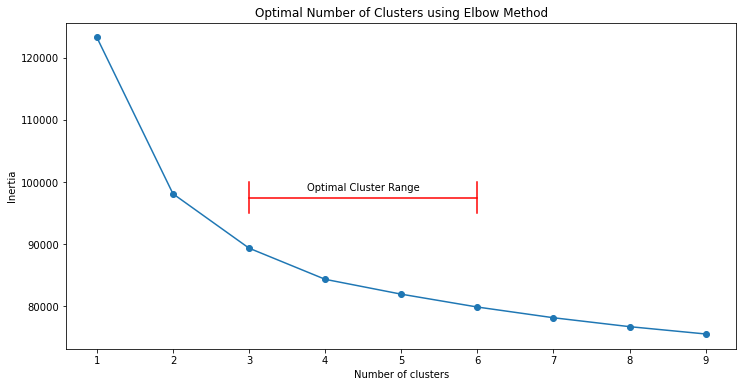

In [28]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn import metrics
from sklearn.manifold import TSNE

sse = []
k_list = range(1, 10)
for k in k_list:
    kmodel = KMeans(n_clusters=k)
    kmodel.fit(data_to_cluster)
    sse.append([k, kmodel.inertia_])
    
plt.figure(figsize=(12,6))
plt.plot(pd.DataFrame(sse)[0], pd.DataFrame(sse)[1], marker='o')
plt.title('Optimal Number of Clusters using Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

plt.plot([3,3],[95000, 100000], color='r')
plt.plot([6,6],[95000, 100000], color='r')
plt.plot([3,6],[97500, 97500], color='r')
plt.annotate('Optimal Cluster Range', xy=(4.5, 100000),  xycoords='data',
            xytext=(4.5, 100000), textcoords='data',
            horizontalalignment='center', verticalalignment='top',
            )



## K-Means Clustering w/ PCA (Cluster Size 11)

In [29]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn import metrics

kmeans_scale = KMeans(n_clusters=11, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(data_to_cluster)
print('KMeans Scaled Silhouette Score: {}'.format(silhouette_score(data_to_cluster, kmeans_scale.labels_, metric='euclidean')))
davies = davies_bouldin_score(data_to_cluster, kmeans_scale.labels_)
calinski = metrics.calinski_harabasz_score(data_to_cluster, kmeans_scale.labels_)
print("For K = {}:\n\tDavies Boudin Score = {}\n\tCalinski Harabasz Score = {}".format(11, davies, calinski))
labels_scale = kmeans_scale.labels_
clusters_scale = pd.concat([data_to_cluster, pd.DataFrame({'cluster_scaled':labels_scale})], axis=1)

KMeans Scaled Silhouette Score: 0.04486735990644756
For K = 11:
	Davies Boudin Score = 2.8152966787566496
	Calinski Harabasz Score = 206.61047232042495


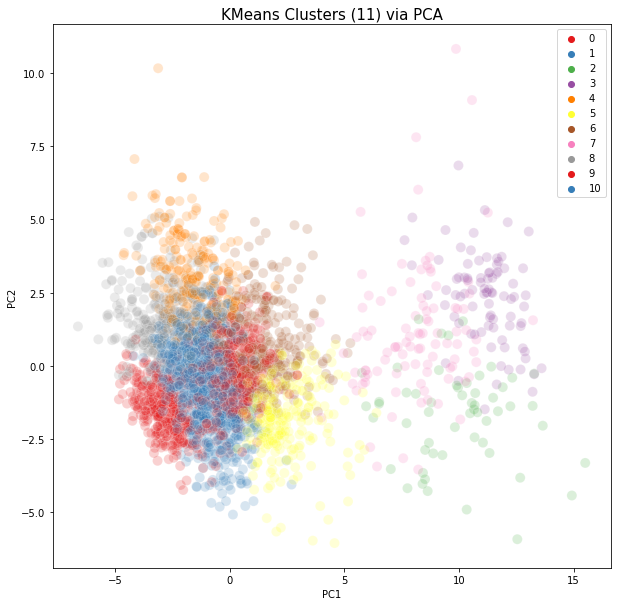

In [30]:
import seaborn as sns
from sklearn.decomposition import PCA

pca2 = PCA(n_components=3).fit(data_to_cluster)
pca2d = pca2.transform(data_to_cluster)
plt.figure(figsize = (10,10))
sns.scatterplot(pca2d[:,0], pca2d[:,1], 
                hue=labels_scale, 
                palette='Set1',
                s=100, alpha=0.2).set_title('KMeans Clusters (11) via PCA', fontsize=15)
plt.legend()
plt.ylabel('PC2')
plt.xlabel('PC1')
plt.show()

The plotly library is used to visualize the clusters in 3D.

In [31]:
import plotly.express as px
import plotly.graph_objects as go

km11_3d = pd.DataFrame(pca2d, columns = ['PC1','PC2','PC3'])
km11_3d['Cluster'] = labels_scale

fig = px.scatter_3d(km11_3d, x='PC1', y='PC2', z='PC3',
              color='Cluster')
fig.update_layout(
    margin=dict(l=20, r=20, t=20, b=20),
    paper_bgcolor="LightSteelBlue",
)
fig.update_traces(marker=dict(size=4
                              ),
                  selector=dict(mode='markers'))
fig.show()

## K-Means Clustering w/ T-SNE (Cluster Size 11)

In [32]:
tsne = TSNE(n_components=3, verbose=1, perplexity=80, n_iter=5000, learning_rate=200)
tsne_scale_results = tsne.fit_transform(data_to_cluster)

[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 3081 samples in 0.000s...
[t-SNE] Computed neighbors for 3081 samples in 0.353s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3081
[t-SNE] Computed conditional probabilities for sample 2000 / 3081
[t-SNE] Computed conditional probabilities for sample 3000 / 3081
[t-SNE] Computed conditional probabilities for sample 3081 / 3081
[t-SNE] Mean sigma: 1.839588
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.985237
[t-SNE] KL divergence after 800 iterations: 1.799292


In [33]:
tsne_df_scale = pd.DataFrame(tsne_scale_results, columns=['tsne1', 'tsne2', 'tsne3'])

In [34]:
kmeans_tsne_scale = KMeans(n_clusters=11, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(tsne_df_scale)
print('KMeans tSNE Scaled Silhouette Score: {}'.format(silhouette_score(tsne_df_scale, kmeans_tsne_scale.labels_, metric='euclidean')))
davies = davies_bouldin_score(tsne_df_scale, kmeans_tsne_scale.labels_)
calinski = metrics.calinski_harabasz_score(tsne_df_scale, kmeans_tsne_scale.labels_)
print("For K = {}:\n\tDavies Boudin Score = {}\n\tCalinski Harabasz Score = {}".format(11, davies, calinski))
labels_tsne_scale = kmeans_tsne_scale.labels_
clusters_tsne_scale = pd.concat([tsne_df_scale, pd.DataFrame({'tsne_clusters':labels_tsne_scale})], axis=1)

KMeans tSNE Scaled Silhouette Score: 0.25187480449676514
For K = 11:
	Davies Boudin Score = 1.0600318352306333
	Calinski Harabasz Score = 1115.7515691790957


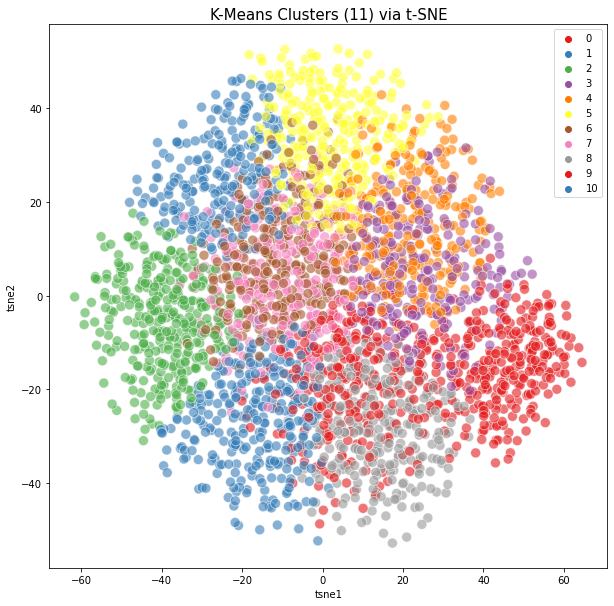

In [35]:
plt.figure(figsize = (10,10))
sns.scatterplot(clusters_tsne_scale.iloc[:,0],clusters_tsne_scale.iloc[:,1],hue=labels_tsne_scale, palette='Set1', s=100, alpha=0.6).set_title('K-Means Clusters (11) via t-SNE', fontsize=15)
plt.legend()
plt.show()

In [36]:
km_tsne_11 = clusters_tsne_scale.rename(columns={'tsne1':'Component 1', 'tsne2':'Component 2', 'tsne3':'Component 3', 'tsne_clusters':'Cluster'})
fig = px.scatter_3d(km_tsne_11, x='Component 1', y='Component 2', z='Component 3',
              color='Cluster')
fig.update_layout(
    margin=dict(l=20, r=20, t=20, b=20),
    paper_bgcolor="LightSteelBlue",
)
fig.update_traces(marker=dict(size=4
                              ),
                  selector=dict(mode='markers'))
fig.show()

# K-Means w/ PCA (Cluster Size 6)

In [37]:
from sklearn.metrics import silhouette_score

kmeans_scale_2 = KMeans(n_clusters=6, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(data_to_cluster)
print('KMeans Scaled Silhouette Score: {}'.format(silhouette_score(data_to_cluster, kmeans_scale_2.labels_, metric='euclidean')))
davies = davies_bouldin_score(data_to_cluster, kmeans_scale_2.labels_)
calinski = metrics.calinski_harabasz_score(data_to_cluster, kmeans_scale_2.labels_)
print("For K = {}:\n\tDavies Boudin Score = {}\n\tCalinski Harabasz Score = {}".format(6, davies, calinski))
labels_scale_2 = kmeans_scale_2.labels_
clusters_scale_2 = pd.concat([data_to_cluster, pd.DataFrame({'cluster_scaled':labels_scale_2})], axis=1)

KMeans Scaled Silhouette Score: 0.06537091284400473
For K = 6:
	Davies Boudin Score = 2.757922483046761
	Calinski Harabasz Score = 333.730194340045


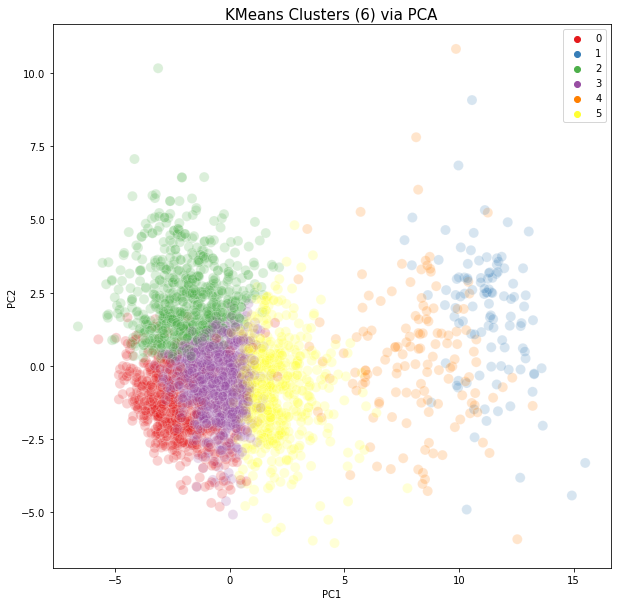

In [38]:
import seaborn as sns

pca2 = PCA(n_components=3).fit(data_to_cluster)
pca2d = pca2.transform(data_to_cluster)
plt.figure(figsize = (10,10))
sns.scatterplot(pca2d[:,0], pca2d[:,1], 
                hue=labels_scale_2, 
                palette='Set1',
                s=100, alpha=0.2).set_title('KMeans Clusters (6) via PCA', fontsize=15)
plt.legend()
plt.ylabel('PC2')
plt.xlabel('PC1')
plt.show()

In [39]:
km6_3d = pd.DataFrame(pca2d, columns = ['PC1','PC2','PC3'])
km6_3d['Cluster'] = labels_scale_2

fig = px.scatter_3d(km6_3d, x='PC1', y='PC2', z='PC3',
              color='Cluster')
fig.update_layout(
    margin=dict(l=20, r=20, t=20, b=5),
    paper_bgcolor="LightSteelBlue",
)
fig.update_traces(marker=dict(size=4
                              ),
                  selector=dict(mode='markers'))
fig.show()

# K-Means w/ t-SNE (Cluster Size 6)

In [40]:
tsne = TSNE(n_components=3, verbose=1, perplexity=80, n_iter=5000, learning_rate=200)
tsne_scale_results = tsne.fit_transform(data_to_cluster)
tsne_df_scale = pd.DataFrame(tsne_scale_results, columns=['tsne1', 'tsne2', 'tsne3'])

[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 3081 samples in 0.000s...
[t-SNE] Computed neighbors for 3081 samples in 0.410s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3081
[t-SNE] Computed conditional probabilities for sample 2000 / 3081
[t-SNE] Computed conditional probabilities for sample 3000 / 3081
[t-SNE] Computed conditional probabilities for sample 3081 / 3081
[t-SNE] Mean sigma: 1.839588
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.982964
[t-SNE] KL divergence after 800 iterations: 1.771218


In [41]:
tsne_df_scale = pd.DataFrame(tsne_scale_results, columns=['tsne1', 'tsne2', 'tsne3'])
kmeans_tsne_scale_2 = KMeans(n_clusters=6, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(tsne_df_scale)
print('KMeans tSNE Scaled Silhouette Score: {}'.format(silhouette_score(tsne_df_scale, kmeans_tsne_scale_2.labels_, metric='euclidean')))
labels_tsne_scale2 = kmeans_tsne_scale_2.labels_
davies = davies_bouldin_score(tsne_df_scale, labels_tsne_scale2)
calinski = metrics.calinski_harabasz_score(tsne_df_scale, labels_tsne_scale2)
print("For K = {}:\n\tDavies Boudin Score = {}\n\tCalinski Harabasz Score = {}".format(11, davies, calinski))
clusters_tsne_scale2 = pd.concat([tsne_df_scale, pd.DataFrame({'tsne_clusters':labels_tsne_scale2})], axis=1)

KMeans tSNE Scaled Silhouette Score: 0.2686035931110382
For K = 11:
	Davies Boudin Score = 1.0835381762180665
	Calinski Harabasz Score = 1276.3253704853664


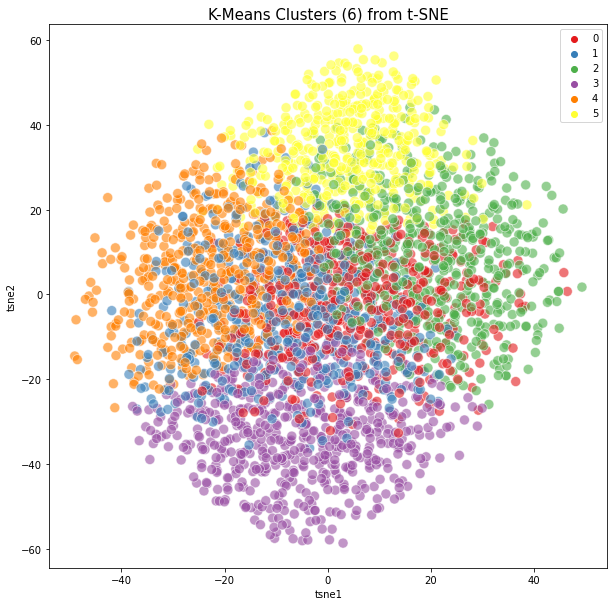

In [42]:
plt.figure(figsize = (10,10))
sns.scatterplot(clusters_tsne_scale2.iloc[:,0],clusters_tsne_scale2.iloc[:,1],hue=labels_tsne_scale2, palette='Set1', s=100, alpha=0.6).set_title('K-Means Clusters (6) from t-SNE', fontsize=15)
plt.legend()
plt.show()

In [43]:
km_tsne_6 = clusters_tsne_scale2.rename(columns={'tsne1':'Component 1', 
                                                 'tsne2':'Component 2', 
                                                 'tsne3':'Component 3', 
                                                 'tsne_clusters':'Cluster'})

fig = px.scatter_3d(km_tsne_6, x='Component 1', y='Component 2', z='Component 3',
              color='Cluster')
fig.update_layout(
    margin=dict(l=20, r=20, t=20, b=20),
    paper_bgcolor="LightSteelBlue",
)
fig.update_traces(marker=dict(size=4
                              ),
                  selector=dict(mode='markers'))
fig.show()

# Agglomerative Clustering

## Agglomerative Clustering w/ PCA (Cluster Size 11)

In [44]:
from sklearn.cluster import AgglomerativeClustering

cls = AgglomerativeClustering(n_clusters = 11, distance_threshold=None).fit(data_to_cluster)
cls_assignment = cls.fit_predict(data_to_cluster)
print('Agglomerative Silhouette Score: {}'.format(silhouette_score(data_to_cluster, cls_assignment, metric='euclidean')))
labels_scale_agg = cls.labels_
davies = davies_bouldin_score(data_to_cluster, labels_scale_agg)
calinski = metrics.calinski_harabasz_score(data_to_cluster, labels_scale_agg)
print("For K = {}:\n\tDavies Boudin Score = {}\n\tCalinski Harabasz Score = {}".format(11, davies, calinski))
clusters_scale_2 = pd.concat([data_to_cluster, pd.DataFrame({'cluster_scaled':labels_scale_agg})], axis=1)

Agglomerative Silhouette Score: 0.010119218695462732
For K = 11:
	Davies Boudin Score = 3.252042763514285
	Calinski Harabasz Score = 173.88482986802052


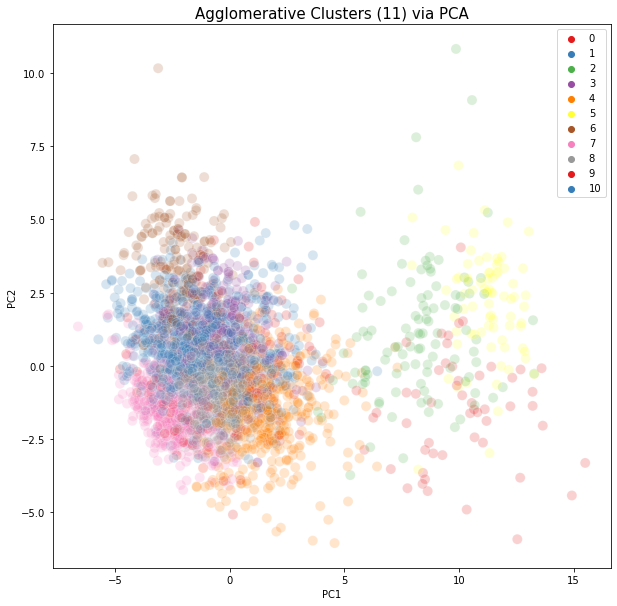

In [45]:
import seaborn as sns

pca_agg = PCA(n_components=3).fit_transform(data_to_cluster)
#pca_agg = pca_agg.transform(data_to_cluster)
plt.figure(figsize = (10,10))
sns.scatterplot(pca_agg[:,0], pca_agg[:,1], 
                hue=labels_scale_agg, 
                palette='Set1',
                s=100, alpha=0.2).set_title('Agglomerative Clusters (11) via PCA', fontsize=15)
plt.legend()
plt.ylabel('PC2')
plt.xlabel('PC1')
plt.show()

In [46]:
agg_3d_pca = pd.DataFrame(pca_agg, columns = ['PC1','PC2','PC3'])
agg_3d_pca['Cluster'] = labels_scale_agg
fig = px.scatter_3d(agg_3d_pca, x='PC1', y='PC2', z='PC3',
              color='Cluster')
fig.update_layout(
    margin=dict(l=20, r=20, t=20, b=20),
    paper_bgcolor="LightSteelBlue",
)
fig.update_traces(marker=dict(size=4
                              ),
                  selector=dict(mode='markers'))
fig.show()

## Agglomerative Clustering w/ t-SNE (Cluster Size 11)


In [47]:
agg_tsne = KMeans(n_clusters=11, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(tsne_df_scale)
print('KMeans tSNE Scaled Silhouette Score: {}'.format(silhouette_score(tsne_df_scale, kmeans_tsne_scale_2.labels_, metric='euclidean')))
labels_tsne_agg = agg_tsne.labels_
davies = davies_bouldin_score(tsne_df_scale, labels_tsne_agg)
calinski = metrics.calinski_harabasz_score(tsne_df_scale, labels_tsne_agg)
print("For K = {}:\n\tDavies Boudin Score = {}\n\tCalinski Harabasz Score = {}".format(11, davies, calinski))
clusters_tsne_agg = pd.concat([tsne_df_scale, pd.DataFrame({'tsne_clusters':labels_tsne_agg})], axis=1)

KMeans tSNE Scaled Silhouette Score: 0.2686035931110382
For K = 11:
	Davies Boudin Score = 1.0578598667488774
	Calinski Harabasz Score = 1112.098169808881


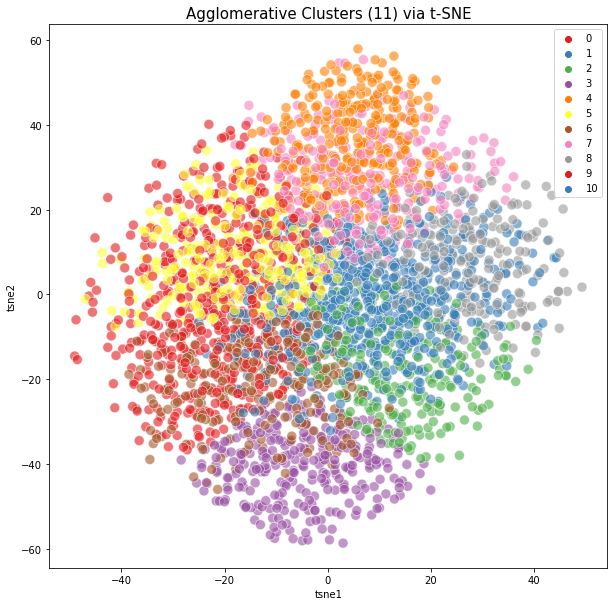

In [48]:
plt.figure(figsize = (10,10))
sns.scatterplot(clusters_tsne_agg.iloc[:,0],clusters_tsne_agg.iloc[:,1],hue=labels_tsne_agg, palette='Set1', s=100, alpha=0.6).set_title('Agglomerative Clusters (11) via t-SNE', fontsize=15)
plt.legend()
plt.show()

In [49]:
agg_tsne = clusters_tsne_agg.rename(columns={'tsne1':'Component 1', 
                            'tsne2':'Component 2', 
                            'tsne3':'Component 3', 
                            'tsne_clusters':'Cluster'})
fig = px.scatter_3d(agg_tsne, x='Component 1', y='Component 2', z='Component 3',
              color='Cluster')
fig.update_layout(
    margin=dict(l=20, r=20, t=5, b=20),
    paper_bgcolor="LightSteelBlue",
)
fig.update_traces(marker=dict(size=4
                              ),
                  selector=dict(mode='markers'))
fig.show()

# Biplot

explained_variance_ratio: [0.28929745 0.09498923 0.06877499 0.04384857 0.03559691 0.03202804
 0.02897931 0.02701329 0.02630452 0.02449735]
sum of explained variance ratios: 0.6713296896575282
singular values: [188.82006759 108.19645673  92.0642718   73.51121199  66.23415626
  62.82623677  59.76127938  57.69851351  56.9365341   54.94591868]
[11.57565517  3.800803    2.7518929   1.75451243  1.42433878  1.28153767
  1.15954887  1.08088262  1.05252238  0.98021233]
3081


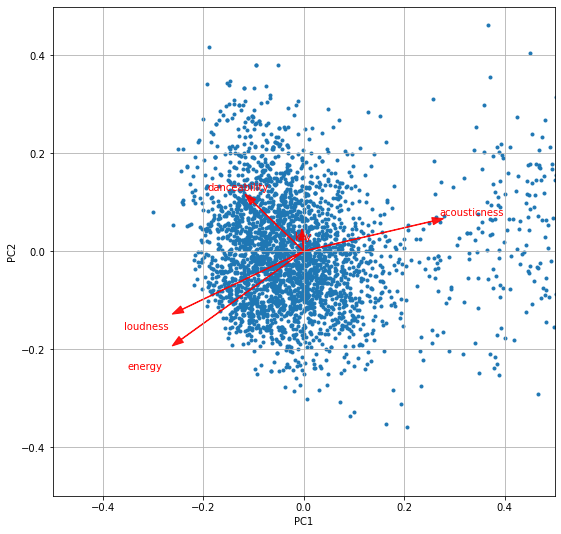

In [50]:
feature_subset_count = 5
pca = PCA(n_components = 10).fit(data_to_cluster)
X_pca = pca.transform(data_to_cluster)
#plot_pca(pca)
feature_names=just_the_data
### Feel free to use this routine to plot your own biplots!
def biplot(score, coeff, maxdim, pcax, pcay, labels=None):
    zoom = 0.5
    pca1=pcax-1
    pca2=pcay-1
    xs = score[:,pca1]
    ys = score[:,pca2]
    n = min(coeff.shape[0], maxdim)
    width = 2.0 * zoom
    scalex = width/(xs.max()- xs.min())
    scaley = width/(ys.max()- ys.min())
    text_scale_factor = 1.3
    fig = plt.gcf()
    fig.set_size_inches(9, 9)
    plt.scatter(xs*scalex, ys*scaley, s=9)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,pca1], coeff[i,pca2],
                  color='r',alpha=0.9, head_width = 0.03 * zoom)
        if labels is None:
            plt.text(coeff[i,pca1]* text_scale_factor,
                     coeff[i,pca2] * text_scale_factor,
                     "Var"+str(i+1), color='r', ha='center', va='center')
        else:
            plt.text(coeff[i,pca1]* text_scale_factor,
                     coeff[i,pca2] * text_scale_factor,
                     labels[i], color='r', ha='center', va='center')
    plt.xlim(-zoom,zoom)
    plt.ylim(-zoom,zoom)
    plt.xlabel("PC{}".format(pcax))
    plt.ylabel("PC{}".format(pcay))
    plt.grid()
plt.figure()
feature_subset = slice(0, feature_subset_count, 1)
biplot(X_pca, np.transpose(pca.components_[0:2, feature_subset]),
       feature_subset_count, 1, 2, labels=feature_names[feature_subset])
print("explained_variance_ratio:", pca.explained_variance_ratio_)
print("sum of explained variance ratios:", np.sum(pca.explained_variance_ratio_))
print("singular values:", pca.singular_values_)
# The variances of the PCs are given by the squares of the singular values of X*, divided by n−1.
# Since they are the eigenvalues of the (n-1)S matrix where S is the correlation matrix of X
print(np.power(pca.singular_values_, 2) / (data_to_cluster.shape[0] - 1))
print(data_to_cluster.shape[0])

# Evaluation

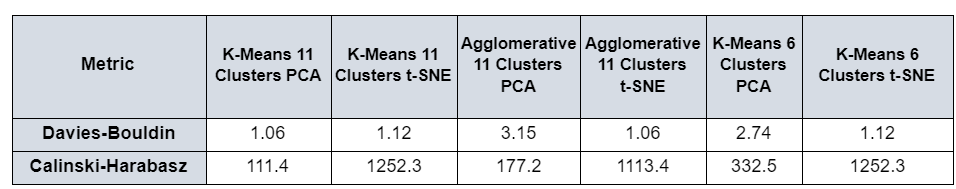

We were interested to see what number of clusters would produce the most distinguishable results and how this would compare to the 11 genres we began with. We found that the lines between genres are heavily blurred, especially when talking about ‘modern’ music - pop, rap, and EDM for example. We found that 6 clusters produced the most distinguishable results when differentiating between songs according to the feature representations we chose to use. Built-in audio characteristics such as key, loudness, and energy for instance may well be similar across different genres, especially considering that popular modern music across the top genres carry very similar qualities according to what the public responds positively to. High tempos, danceability, and valence (emotional positivity) are rife among popular music, and these songs are usually the ones inputted into spotify playlists. The PCA biplot that was generated Shows that the first principal components mostly depended on acousticness, loudness, energy, and danceability, although acousticness was inversely related with loudness and energy. This can be attributed to the classical class having large acoustic values. The internal computation of these metrics were loosely defined on their development site, but according to their metrics, genres blur to a very high degree according to these characteristics. 

It is interesting, however, to observe the differences in scores across different clustering methods as applied to our dataset of 3098 songs. We used the Davies Bouldin and Calinski Harabasz scores as our main evaluation metrics. The Davies-Bouldin score dictates the average similarity between clusters, essentially measuring how much overlap exists between separate clusters. Clusters which are more distinct and farther apart from each other will receive a better score, with lower scores indicating better clusters. Overall there was not a lot of variance in the Davies-Bouldin scores, with the K-Means-PCA 11 cluster group having the lowest score, and therefore the most distinguishability among clusters. This came out to be similar to the t-SNE K-means 11 cluster group. The worst score and therefore the most indistinguishable clusters by similarity and distance were in the agglomerative-PCA 11 cluster group and the K-means-PCA 6 cluster group. Interestingly, the K-means 6 cluster group prepared with t-SNE scored much better on the Davies-Bouldin index. These different groups can be referenced visually with the 3-D plots in the appendix section.

The second metric we used to evaluate our clusters was the Calinski-Harabasz index. The Calinski-Harabasz index, also known as Variance Ratio Criterion, is defined as the ratio between within-cluster dispersion and between-cluster dispersion. In this case, a higher score indicates better performance. The Calinski-Harabasz score rewards clusters that are both dense and well-separated, which is intuitive for clustering. In this case, we saw a very clear relationship between the dimensionality reduction technique and the Calinski-Harabasz score. When PCA was used, we saw scores ranging from 111-332, with the K-means-PCA 6 cluster group scoring the best. However, when t-SNE was used we observed a significant increase in scores as compared to the PCA groups. In this case, the K-mean-PCA 6 cluster group was still the best performer at 1252, but the other two t-SNE groups also scored above 1000 on the Calinski-Harabasz score. This proved to us that t-SNE resulted in much denser clusters that were also more distinct. Once again, these different groups can be referenced visually with the 3-D plots in the appendix section.

# Discussion

It was learned that there is a lot of crossover between the main genres of music, but the K-means t-SNE 6 cluster model best represents the differences between the genres. Although 11 official genres were included in the dataset, it was surprising to find that the songs included were best represented by six different clusters. If we had more time and resources, we could compile more songs into our dataset as well as incorporate more subgenres which would yield interesting results. It would also be interesting to incorporate more characteristics of the spectral waveform for each audio sample to see if those features play a larger role in the classification of songs. 